`Martín Alexis Martínez Andrade`

**This notebook was made in Google Colab.**

# Libraries

* pandas
* numpy
* matplotlib
* scipy

# P4: Statistic Test

Prove that labeled data is different by running ANOVA + T test or Kruskall Wallis test.

## (Optional) Download modified_clean_data.csv from Dropbox

In [41]:
# download file from dropbox
!wget -O modified_clean_data.csv https://www.dropbox.com/scl/fi/8pnm0884bksvfcyxep4ec/modified_clean_data.csv?rlkey=n8qd7e299e1bydtfiwemsdeig&st=89yik26c&dl=1

--2025-09-22 04:39:29--  https://www.dropbox.com/scl/fi/8pnm0884bksvfcyxep4ec/modified_clean_data.csv?rlkey=n8qd7e299e1bydtfiwemsdeig
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ucf6f8d60112bb1efecf170ccceb.dl.dropboxusercontent.com/cd/0/inline/Cx0_3luW1Qj_bvy9DEElH3E7VEmDq3hw_V6phszY0pUGnhTSYgW8ZwUsMgeirB65Ccuz6tS0cqx7CjrtJLC-wLixf6QP12d8PTUgj4iNwqBD_yDpTVDWlRBWb6tGhEz0iLWfQq1jtIWi1DPbI3fAkUMI/file# [following]
--2025-09-22 04:39:30--  https://ucf6f8d60112bb1efecf170ccceb.dl.dropboxusercontent.com/cd/0/inline/Cx0_3luW1Qj_bvy9DEElH3E7VEmDq3hw_V6phszY0pUGnhTSYgW8ZwUsMgeirB65Ccuz6tS0cqx7CjrtJLC-wLixf6QP12d8PTUgj4iNwqBD_yDpTVDWlRBWb6tGhEz0iLWfQq1jtIWi1DPbI3fAkUMI/file
Resolving ucf6f8d60112bb1efecf170ccceb.dl.dropboxusercontent.com (ucf6f8d60112bb1efecf170ccceb.dl.dropboxusercontent.com)... 162.12

## Load dataset

In [42]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pylab as py
from scipy import stats
from typing import List


df = pd.read_csv(f"modified_clean_data.csv")

## What Analysis of Variance will be used for

We want to know whether several categories of length of reviews (very short [bottom 25%], short [25%], long [25%], very long [top 25%]) produce similar helpfulness scores, or whether one among them may produce higher helpfulness scores than the rest.

For this practice, let's drop datapoints that have null values for the Helpfulness Score column.

In [43]:
df.dropna(subset=["HelpfulnessScore"], inplace=True)

## Assumptions

In the analysis of variance (ANOVA) procedure, the $F$ test is based on the assumption that independent random samples are taken from normal populations with equal variances.

Let's see if these assumptions are correct for our dataset.

### Normality

In [44]:
def plot_distributions(df: pd.DataFrame, independent_var_column_name: str,
        dependent_var_column_name: str) -> List[pd.Series]:
    groups = [df[df[independent_var_column_name] == cat][dependent_var_column_name] for cat in df[independent_var_column_name].unique()]

    # plot distribution of each group
    for cat, group in zip(["very short", "short", "long", "very long"], groups):
        print(group.shape[0])
        plt.figure(figsize=(10, 6))
        plt.hist(group, bins=20, alpha=0.5, label=f'Group')
        plt.title(f'{cat} | Distribution of {dependent_var_column_name}')
        plt.xlabel(dependent_var_column_name)
        plt.ylabel('Frequency')
        plt.show()

    return groups


49014


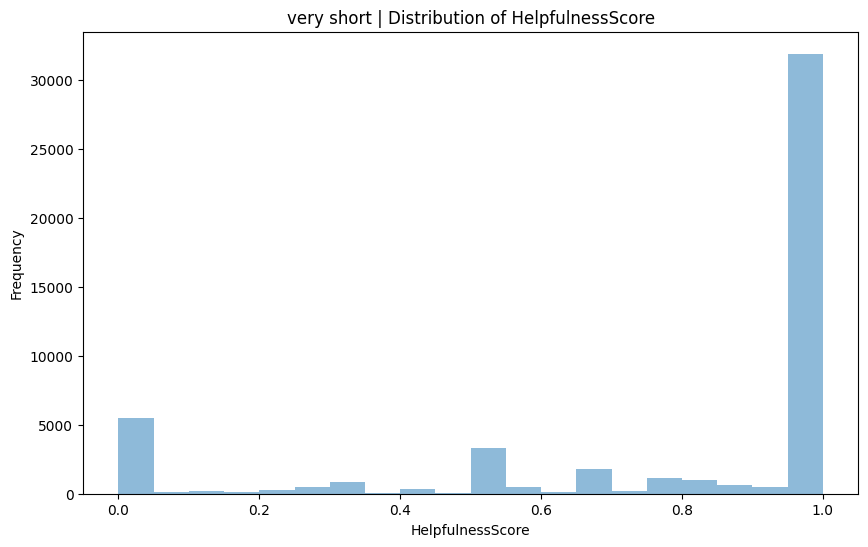

54517


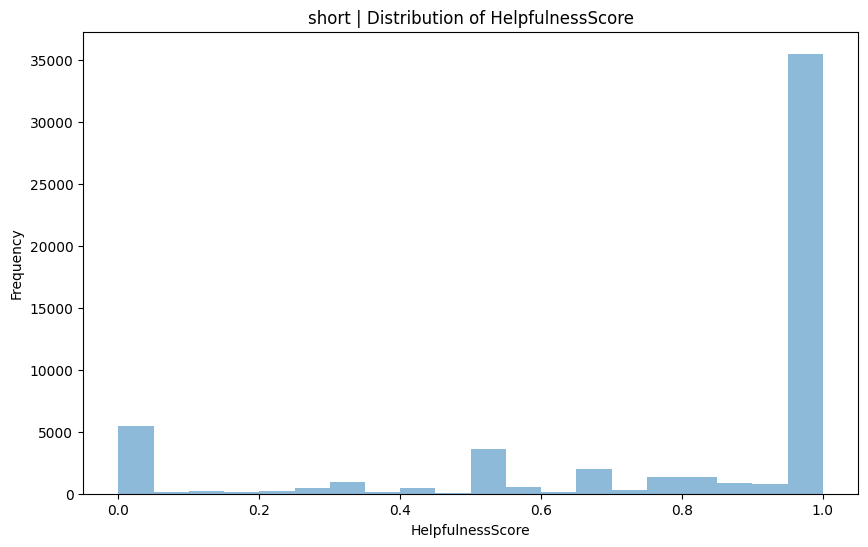

45865


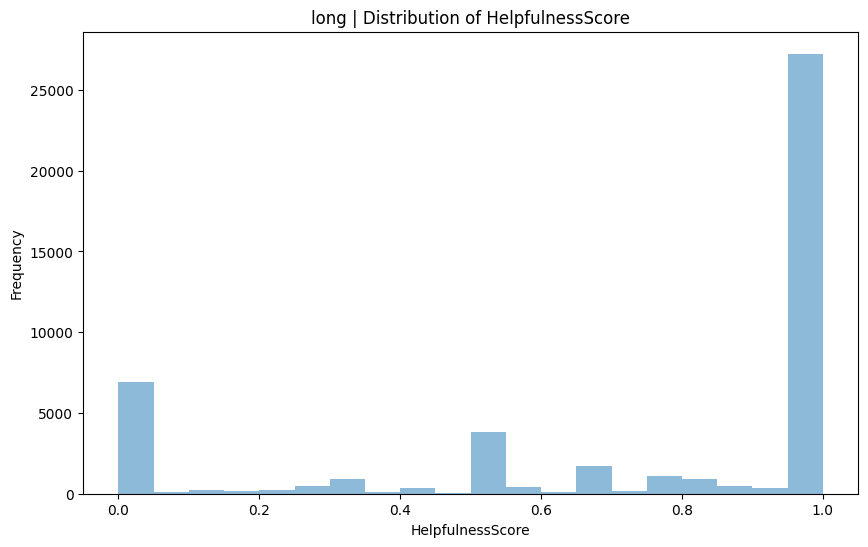

61453


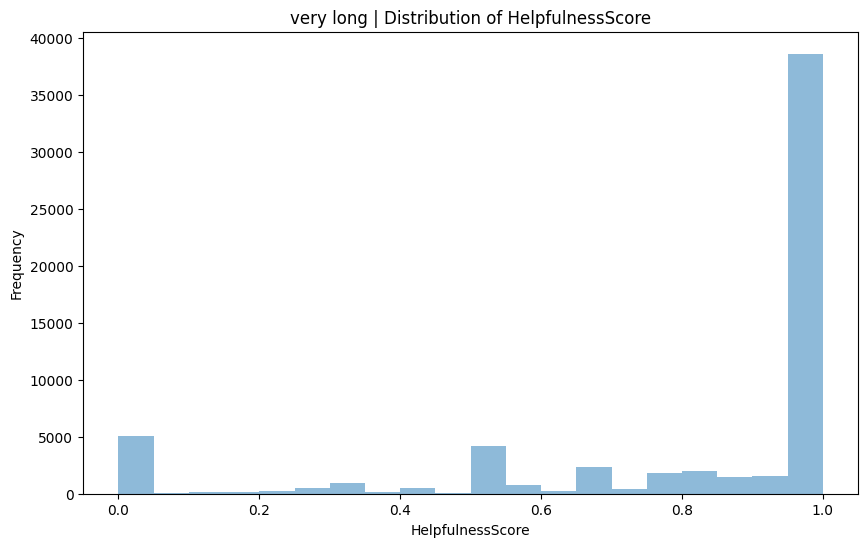

In [45]:
groups = plot_distributions(df, "LengthCategory", "HelpfulnessScore")

As you might instantly realize, the distributions are not normal. Because of this, the ANOVA test cannot be run (because of the F test, which requires normality, and having a non-normal distribution would lead to inaccuracies). Instead, the Kruskal-Wallis test will be used.

Let's prove non-normality with a Quantile-Quantile plot. All of the normality tests (Shapiro, Kolmogorov-Smirnov, etc.) almost certainly reject normality when applied to large datasets, even if they're normal; as we have hundreds of thousands of datapoints, it's better to use a Quantile-Quantile plot.

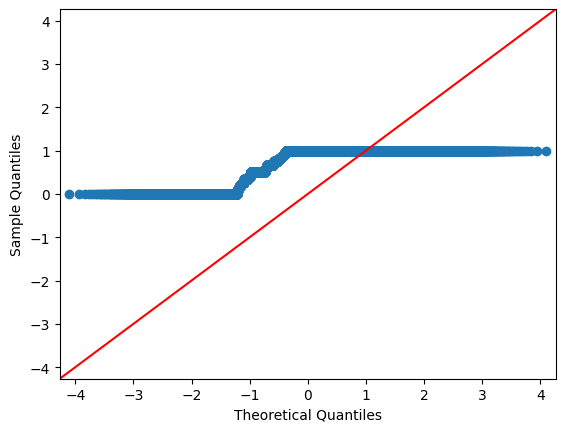

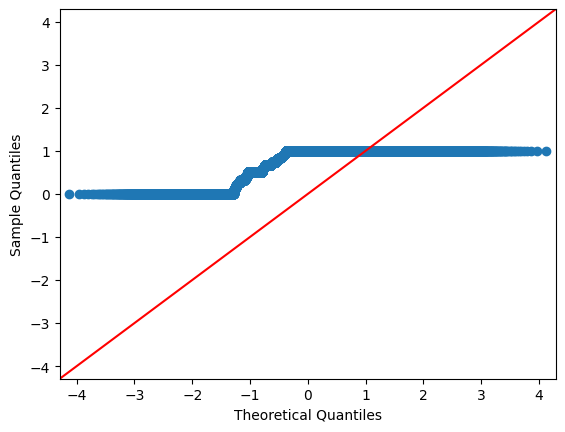

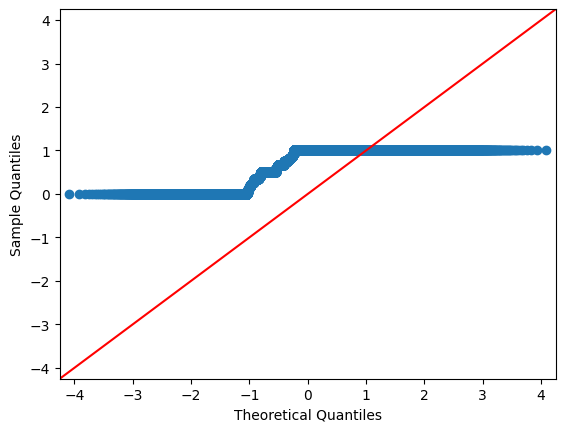

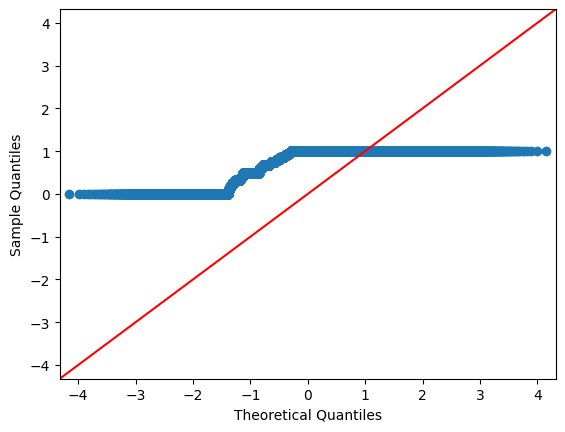

In [46]:
for group in groups:
    sm.qqplot(group, line ='45')
    py.show()

In the Quantile-Quantile plots, none of the distributions match the 45° line at all, so they do not align with a normal distribution.

Let's use the Kruskal-Wallist test.

## Kruskal-Wallis test

### Assumptions

Like other nonparametric techniques, the Kruskal-Wallis procedure requires no assumptions about the actual form of the probability distributions. Nonetheless, we still have to make the following assumptions:

1. [✔] **Independence of Observations**: Each observation within the dataset should be independent of all other observations, meaning one data point does not influence another.
2. [✔] **Ordinal or Continuous Dependent Variable**: The dependent variable should be measured on an ordinal scale or a continuous scale.
3. [✔] **Independence of Samples**: The samples from each group must be independent of each other.



### Procedure

We let the sample sizes to be unequal, $n_i$ for $i=1,2,...,k$ represents the size of the sample drawn from the $i$th population.

We combine all the $\sum\limits^k_{i=1}{n_i}=n$ observations and rank them from 1 (smallest) to $n$ (largest). If two or more observations are tied for the same rank, then the average of the ranks that would have been assigned to these observations is assigned to each member of the tied group.

Let $R_i$ denote the sum of the ranks of the observations from population $i$ and let $\bar{R_i}= \frac{R_i}{n_i}$ denote the average of the ranks in $i$.

Let $\bar{R}$ be the overall average of all of the ranks:

$
\bar{R} = \frac{1}{k} \cdot \sum\limits^k_{i=1}{\bar{R_i}}
$,

now we can consider $V$, the rank analogue () of SST (SST is the *total sum of squares* used in the F-test-based ANOVA), which is **computed by using the ranks rather than the actual values of the measurements**:

$
V = \sum\limits^k_{i=1}{n_i(\bar{R_i} - \bar{R})^2}.
$

---

If the null hypothesis is true and the populations do not differ, we would expect the $\bar{R_i}$ values to be approximately equal and the resulting value of V to be relatively small. If the alternative hypothesis is true, we would expect this to be exhibited in differences among the values of $\bar{R_i}$, leading to a large value for V. Notice that $\bar{R} =$ sum of the first $n$ integers $/n=[n(n+1)/2]/n=(n+1)/2$ and thus that:

$
V = \sum\limits^k_{i=1}{n_i(\bar{R_i}-\frac{n+1}{2})^2}
$

Instead of focusing on V, Kruskal and Wallis (1952) considered the statistic $H = \frac{12V}{n(n+1)}$, which, after performing in V the squaring of each term in the sum and adding the resulting values, may be rewritten as:

$H = \frac{12}{n(n+1)} \sum\limits^{k}_{i=1}{(\frac{R^2_i}{n_i})} - 3(n+1)$

The null hypothesis is rejected if the value of $H$ is large. The corresponding $\alpha$-level test calls for rejection of the null hypothesis in favor of the alternative if $H>h(\alpha)$, where $h(\alpha)$ is such that, when $H_0$ is true, $P[H>h(\alpha)]=\alpha$.

In short, Kruskal-Wallis tests whether several treatment produce similar outcomes, or whether one among them may produce higher or lower outcomes than the rest; its test statistics is $H$, and $H_0$ is rejected if $H>x^2_\alpha$ with $(k-1)$ degrees of freedom.


In [47]:
def kruskal_wallis(groups: List[pd.Series]):
    H, p = stats.kruskal(*groups)
    return H, p

def run_kruskal_wallis(df: pd.DataFrame or List[pd.Series],
        independent_var_column_name: str, dependent_var_column_name: str,
        significance_level: float = 0.05, plot: bool = False, describe: bool = True,
        drop_nulls: bool = True
    ):
    # get groups
    if isinstance(df, list) and all(isinstance(group, pd.Series) for group in df):
        groups = df
    else:
        groups = [df[df[independent_var_column_name] == cat][dependent_var_column_name] for cat in df[independent_var_column_name].unique()]

    if drop_nulls:
        # drop nulls
        print("\n~ ~ ~ NULLS ~ ~ ~")
        for group in groups:
          print(group.isna().sum(), "/", group.shape[0])
        groups = [group.dropna() for group in groups]
        print("Dropped")
        print("~ ~ ~ NULLS ~ ~ ~\n")

    if plot:
        print("\n~ ~ ~ PLOT ~ ~ ~")
        # plot distribution of each group
        for group in groups:
            print(group.shape[0])
            plt.figure(figsize=(10, 6))
            plt.hist(group, bins=20, alpha=0.5, label=f'Group')
            plt.title(f'Distribution of {dependent_var_column_name}')
            plt.xlabel(dependent_var_column_name)
            plt.ylabel('Frequency')
            plt.show()
        print("~ ~ ~ PLOT ~ ~ ~\n")

    if describe:
        print("\n~ ~ ~ DESCRIBE ~ ~ ~")
        for cat, group in zip(["very short", "short", "long", "very long"], groups):
            print(cat)
            print(group.describe())
        print("~ ~ ~ DESCRIBE ~ ~ ~\n")

    print("\n~ ~ ~ KRUSKAL-WALLIS ~ ~ ~")
    H, p = kruskal_wallis(groups)
    print(f"Kruskal-Wallis H = {H:.4f}, p = {p:.4e}")
    print("~ ~ ~ KRUSKAL-WALLIS ~ ~ ~\n")

    print("\n~ ~ ~ HYPOTHESIS ~ ~ ~")
    reject_null_hypothesis = p < significance_level
    if p < significance_level:
        print(f"Reject null hypothesis with significance level {significance_level}: there is at least one group that produces better (or worse) outcomes than the rest.")
    else:
        print("Fail to reject null hypothesis: all groups produce similar outcomes.")
    print("~ ~ ~ HYPOTHESIS ~ ~ ~\n")

    return H, p, reject_null_hypothesis


In [48]:
run_kruskal_wallis(df, "LengthCategory", "HelpfulnessScore", describe=True, drop_nulls=False)


~ ~ ~ DESCRIBE ~ ~ ~
very short
count    49014.000000
mean         0.787498
std          0.345458
min          0.000000
25%          0.666667
50%          1.000000
75%          1.000000
max          1.000000
Name: HelpfulnessScore, dtype: float64
short
count    54517.000000
mean         0.799443
std          0.332574
min          0.000000
25%          0.666667
50%          1.000000
75%          1.000000
max          1.000000
Name: HelpfulnessScore, dtype: float64
long
count    45865.000000
mean         0.736016
std          0.376023
min          0.000000
25%          0.500000
50%          1.000000
75%          1.000000
max          1.000000
Name: HelpfulnessScore, dtype: float64
very long
count    61453.000000
mean         0.809919
std          0.313780
min          0.000000
25%          0.666667
50%          1.000000
75%          1.000000
max          1.000000
Name: HelpfulnessScore, dtype: float64
~ ~ ~ DESCRIBE ~ ~ ~


~ ~ ~ KRUSKAL-WALLIS ~ ~ ~
Kruskal-Wallis H = 700.0367, p = 2.0

(np.float64(700.0366868118732), np.float64(2.0610305061581468e-151), np.True_)

We have a $p$-value of almost 0. Kruskal-Wallis is sensitive to really small differences in the distributions when the dataset is too large. Now, this is not a problem; some statistical tests are misinterpreted. As explained before, Kruskal-Wallis determines whether at least one group produces better or worse outcomes than the other groups. As seen graphically in the second practice, there's a small difference in, for example, the mean of the Helpfulness Score of each of the length categories. Kruskal-Wallis finds with complete certainty this difference in the distributions; this doesn't mean that difference is *meaningful*, it's just *statistically significant*.

A *statistically significant* difference is a difference between poblations (groups) that is proved to not be due to a random coincidence in the samples. A *meaningful* difference (*practical significance*) is obtained by considering effect sizes and understanding the context of the study and with domain knowledge; it's the real-world importance of the difference. A difference (or finding, in general) can be statistically significant but not practically meaningful, such as a tiny, but real, improvement in a medication's effectiveness, or a practically meaningful difference may not be statistically significant due to small sample sizes.

In the case of this practice, each length category has, for example, really similar means: 0.79, 0.8, 0.74, 0.8; the $p$-value obtained in the Kruskal-Wallis test was $p=2.061 \times 10^{-151} ≈ 0$, so the null hypothesis is rejected, meaning that at least one of the length categories produces better (or worse) helpfulness scores than the other categories. Looking at the means, the *long* category produces significantly lower helpfulness scores than the other categories; this significance is highlighted because of the huge size of the dataset. Is this difference *meaningful*? It depends on the interpretation of the analyst; in this example, there's a 0.06 difference in the helpfulness score, which might not be a meaningful difference.